In [2]:
import xarray as xr
import numpy as np
from pathlib import Path
import gsw
from xarray import open_mfdataset, open_dataset
from matplotlib import pyplot as plt



# Utilities 
def find_grid_files(grid_type, years, nest, model, delta_t, folder = 'output'): 
    experiment_path = Path('/gxfs_work/geomar/smomw355/model_data/ocean-only/')
    nest_part = '1_' if nest else '' 

    if len(grid_type) < 2:
        grid_type = f'grid_{grid_type}'

    grid_files = (experiment_path / model / 'nemo' / folder).glob(f'{nest_part}{model}_{delta_t}_*_*_{grid_type}.nc')
    grid_files = list(grid_files)
    
    result_files = []
    for file in grid_files:
        start_year = int(str(file).split('/')[-1].split('_')[- (3 + grid_type.count('_'))][:4])
        
        if (years[0] is None or start_year >= years[0]) and \
           (years[1] is None or start_year < years[1]):
            result_files.append(file)
    
    return sorted(result_files)

def load_dataset_from_grid_type(grid_type, years, nest, model, delta_t, chunks = {"time_counter" : 2,"y": 2, "x": None}, **kwargs):
    files_list = find_grid_files(grid_type, years, nest, model, delta_t, **kwargs)
    grid = open_mfdataset(
        files_list, # type: ignore
        chunks= chunks,
        combine='by_coords'
    )
    return grid

def load_masks(nest, model):

    if str.startswith(model, 'VIKING20X.L46-KFS003'):
        # All the mask for the long runs VIKING20X.L46-KFS003-2nd, ... are placed in the original experiment
        model = 'VIKING20X.L46-KFS003' 
    
    nest_part = '1_' if nest else ''
    
    mask_mesh = open_dataset(
        f'/gxfs_work/geomar/smomw355/model_data/ocean-only/{model}/nemo/suppl/{nest_part}mesh_mask.nc',
        decode_cf=False,
        chunks={'y': 100, 'x':100, 'z': -1},
    )

    if model == 'VIKING20X.L46-KFS003' and not nest:
        nest_part = 'ori_'

    mask_glo = open_dataset(
        f'/gxfs_work/geomar/smomw355/model_data/ocean-only/{model}/nemo/suppl/{nest_part}new_maskglo.nc',
        decode_cf=False,
        chunks={'Y':100, 'X':100, 'z': -1}
    )

    mask_mesh = mask_mesh.squeeze()
    mask_glo = mask_glo.rename({'X':'x', 'Y':'y'}).squeeze() # Rename coordinates to have the same name as the data file
    
    return mask_mesh, mask_glo



In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import os

cluster = SLURMCluster(
    cores=2,
    # processes=1,
    memory="5GB",
    shebang='#!/usr/bin/env bash',
    queue="base",
    walltime="01:30:00",
    local_directory='/tmp',
    death_timeout="15s",
    interface="ib0",
    log_directory=f'/gxfs_work/geomar/smomw507/geomar/rapid-geostrophic-reconstruction/logs',
    )

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.18.5.73:8787/status,
Dashboard: http://172.18.5.73:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.18.5.73:45561,Workers: 0
Dashboard: http://172.18.5.73:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /gxfs_work/geomar/smomw507/geomar/rapid-geostrophic-reconstruction/logs/dask-worker-%J.err
#SBATCH -o /gxfs_work/geomar/smomw507/geomar/rapid-geostrophic-reconstruction/logs/dask-worker-%J.out
#SBATCH -p base
#SBATCH -n 1
#SBATCH --cpus-per-task=2
#SBATCH --mem=5G
#SBATCH -t 01:30:00

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/bin/python -m distributed.cli.dask_worker tcp://172.18.5.73:45561 --name dummy-name --nthreads 1 --memory-limit 2.33GiB --nworkers 2 --nanny --death-timeout 15s --local-directory /tmp --interface ib0



In [4]:
cluster.scale(80)

In [5]:
cluster

SLURMCluster(849d9ec7, 'tcp://172.18.5.73:45561', workers=80, threads=80, memory=186.40 GiB)

In [6]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster(n_workers=8, threads_per_worker=1, memory_limit=750e6,
#                        silence_logs=50)
# client = Client(address=cluster)

In [6]:
coordinates = [
    [26.52,-76.74],
    [26.50,-76.50],# WB3
    [26.99,-16.23],
    [24.52,-49.8], # MAR12
    [24.52,-41.21], # MAR3
    [27.9, -13.5], # EBH4
    [27.75, -13.75], # EBH3
    [27.55, -14.2], # EBH2
    [27.1, -15.4], # EBH1
    [26.55,-76.7], # WB2
    [26.48, -76.65], # WBH2
    [24.52,-24.1] # EB1
    ]


In [7]:
mask, mask_glo = load_masks(nest = True, model = 'VIKING20X.L46-KFS003')

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(20.0, 30.0)

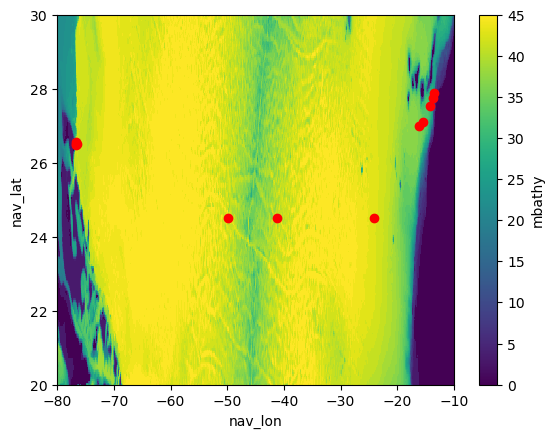

In [8]:
mask.mbathy.assign_coords(nav_lon = mask.nav_lon, nav_lat = mask.nav_lat).plot(x = 'nav_lon', y = 'nav_lat')

plt.scatter([c[1] for c in coordinates], [c[0] for c in coordinates], c = 'r')

plt.xlim(-80, -10)
plt.ylim(20, 30)

In [9]:
import pandas as pd
from sklearn.metrics.pairwise import haversine_distances
def get_mask_indices(coordinates):
    mask_mesh = mask
    c_mask_mesh = mask_mesh.assign_coords({'x': np.arange(mask_mesh.x.shape[0]), 'y': np.arange(mask_mesh.y.shape[0])})

    cutted_c_mask = c_mask_mesh
    # .where(
    #     ((self.boundary.lat_min <= mask_mesh.nav_lat) & (mask_mesh.nav_lat <= self.boundary.lat_max) & (self.boundary.lon_min <= mask_mesh.nav_lon) & (mask_mesh.nav_lon <= self.boundary.lon_max)).compute()
    #     , drop = True)
    print('use only data within boundaries')

    lonlat_model = np.vstack((cutted_c_mask.where(cutted_c_mask.tmaskutil > 0).nav_lon.stack({'list': ['x', 'y']}).values, cutted_c_mask.where(cutted_c_mask.tmaskutil > 0).nav_lat.stack({'list': ['x', 'y']}).values)).T
    
    print('created mask lat/lons')
    
  
    coordinates_df = pd.DataFrame(coordinates, columns = ['latitude', 'longitude'])
    # time_df = pd.DataFrame(pd.date_range('2004-01-15',freq = 'MS', periods = 12 * 16), columns = ['time'])
    # coordinates_df['key'] = 0
    # time_df['key'] = 0
    # argo_frame = time_df.set_index('key').join(coordinates_df.set_index('key'), 'key').reset_index().assign(depth = 6000)

    lonlat_argo = np.vstack((coordinates_df.longitude, coordinates_df.latitude)).T.astype(float)

    non_nan_model_mask = np.all(~np.isnan(lonlat_model), axis = -1)

    argo_indices_without_nans = np.nanargmin(haversine_distances(np.radians(lonlat_model[non_nan_model_mask]), np.radians(lonlat_argo)), axis= 0)

    non_nan_model_indices = np.argwhere(non_nan_model_mask).squeeze()
    argo_indices = non_nan_model_indices[argo_indices_without_nans]


    XY_indices = np.array([*cutted_c_mask.where(cutted_c_mask.tmaskutil > 0).stack({'list': ['x', 'y']}).list.isel(list = xr.DataArray(argo_indices)).values])

    return XY_indices

In [10]:
c_inds = get_mask_indices(coordinates)


use only data within boundaries
created mask lat/lons


In [11]:


zlevels_at_coordinates = mask.mbathy.isel(
    x = xr.DataArray(c_inds[:, 0]),
    y = xr.DataArray(c_inds[:, 1])
)

In [12]:
mooring_names = ['_', 'WB3', '_' , 'MAR12', 'MAR3', 'EBH4', 'EBH3', 'EBH2', 'EBH1', 'WB2', 'WBH2', 'EB1']

In [13]:
[print(f'{n}: {d}') for n,d in zip(mooring_names, mask.nav_lev.values[zlevels_at_coordinates])]

_: 3892.94970703125
WB3: 5125.9189453125
_: 3650.7119140625
MAR12: 5125.9189453125
MAR3: 5375.1767578125
EBH4: 989.2288818359375
EBH3: 1470.8929443359375
EBH2: 2266.45361328125
EBH1: 3410.755859375
WB2: 4137.046875
WBH2: 4877.30322265625
EB1: 5375.1767578125


[None, None, None, None, None, None, None, None, None, None, None, None]

In [14]:
T_grid = load_dataset_from_grid_type('T', years = [2004, 2020], nest = True, model = 'VIKING20X.L46-KFS003', delta_t = '1d', chunks = {"time_counter" : 1,"y": 100, "x": 1000})


T_grid = T_grid.assign_coords({'x': np.arange(T_grid.x.shape[0]), 'y': np.arange(T_grid.y.shape[0])})

In [15]:
mooring_array = xr.concat([T_grid.votemper, T_grid.vosaline], dim = 'variable').isel(
    x = xr.DataArray(c_inds[:, 0]),
    y = xr.DataArray(c_inds[:, 1])
).rename(dim_0 = 'moorings').assign_coords(variable = ['temp', 'salt'], moorings = mooring_names)
mooring_array

<xarray.DataArray 'votemper' (variable: 2, time_counter: 5844, deptht: 46,
                              moorings: 12)>
dask.array<transpose, shape=(2, 5844, 46, 12), dtype=float32, chunksize=(1, 1, 46, 12), chunktype=numpy.ndarray>
Coordinates:
  * deptht         (deptht) float32 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
    nav_lat        (moorings) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    nav_lon        (moorings) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2004-01-01T12:00:00 ... 2019...
    x              (moorings) int64 434 439 1644 973 1145 ... 1661 435 436 1487
    y              (moorings) int64 1275 1274 1285 1230 ... 1287 1276 1274 1230
  * variable       (variable) <U4 'temp' 'salt'
  * moorings       (moorings) <U5 '_' 'WB3' '_' 'MAR12' ... 'WB2' 'WBH2' 'EB1'
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  300 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 300 s) time_counter: mean

In [16]:
mooring_array_computed = mooring_array.compute()

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 14.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [17]:
mooring_array_computed.to_netcdf('/gxfs_work/geomar/smomw507/geomar/rapid-geostrophic-reconstruction/data/mooring_data.nc')

In [18]:
mooring_array_computed

<xarray.DataArray 'votemper' (variable: 2, time_counter: 5844, deptht: 46,
                              moorings: 12)>
array([[[[24.286896, 24.385792, 21.338356, ..., 24.307781, 24.304644,
          23.058788],
         [24.281013, 24.380472, 21.33839 , ..., 24.301607, 24.29877 ,
          23.058779],
         [24.277721, 24.377487, 21.3384  , ..., 24.298166, 24.29542 ,
          23.05874 ],
         ...,
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ]],

        [[24.249252, 24.37213 , 21.31744 , ..., 24.273918, 24.27539 ,
          22.996464],
         [24.240915, 24.363136, 21.317112, ..., 24.265244, 24.266626,
          22.996473],
         [24.23645 , 24.358213, 21.316786, ..., 24.260406, 24.261602,
          22.996445],
...
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ]],

        [[36.58307 , 36.53527 , 36.812298, ..., 36.57021 , 36.561527,
          37.157948],
         [36.596504, 36.555744, 36.81227 , ..., 36.585148, 36.57755 ,
          37.157936],
         [36.602062, 36.56294 , 36.81225 , ..., 36.592   , 36.58406 ,
          37.157913],
         ...,
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ]]]], dtype=float32)
Coordinates:
  * deptht         (deptht) float32 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
    nav_lat        (moorings) float32 26.52 26.48 26.99 ... 26.57 26.48 24.52
    nav_lon        (moorings) float32 -76.75 -76.5 -16.25 ... -76.7 -76.65 -24.1
    time_centered  (time_counter) datetime64[ns] 2004-01-01T12:00:00 ... 2019...
  * time_counter   (time_counter) datetime64[ns] 2004-01-01T12:00:00 ... 2019...
    x              (moorings) int64 434 439 1644 973 1145 ... 1661 435 436 1487
    y              (moorings) int64 1275 1274 1285 1230 ... 1287 1276 1274 1230
  * variable       (variable) <U4 'temp' 'salt'
  * moorings       (moorings) <U5 '_' 'WB3' '_' 'MAR12' ... 'WB2' 'WBH2' 'EB1'
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  300 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 300 s) time_counter: mean

In [1]:
1

1

In [4]:
load_dataset_from_grid_type('moc', [2004,2005], True, 'VIKING20X.L46-KFS003', '1d', folder = 'derived')

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<xarray.Dataset>
Dimensions:       (y: 2499, x: 1, depthw: 46, time_counter: 366)
Coordinates:
  * depthw        (depthw) float32 -0.0 -6.194 -12.84 ... -5.5e+03 -5.75e+03
  * time_counter  (time_counter) datetime64[ns] 2004-01-01T12:00:00 ... 2004-...
Dimensions without coordinates: y, x
Data variables:
    nav_lon       (y, x) float32 dask.array<chunksize=(2, 1), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(2, 1), meta=np.ndarray>
    zomsfglo      (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 46, 2, 1), meta=np.ndarray>
    zomsfglo_sh   (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 46, 2, 1), meta=np.ndarray>
    zomsfglo_bt   (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 46, 2, 1), meta=np.ndarray>
    zomsfglo_ag   (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 46, 2, 1), meta=np.ndarray>
    zomsfatl      (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 46, 2, 1), meta=np.ndarray>
    zomsfatl_sh   (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 46, 2, 1), meta=np.ndarray>
    zomsfatl_bt   (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 46, 2, 1), meta=np.ndarray>
    zomsfatl_ag   (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 46, 2, 1), meta=np.ndarray>
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Partial step computation